# 1.0 Convolutional Neural Networks (CNN)

**Convolutional neural networks** (CNNs) emerged from the study of the brain’s visual
cortex, and they have been used in image recognition since the 1980s. In the last few
years, thanks to the increase in computational power, the amount of available training
data, and the tricks presented previous lessons for training deep nets, CNNs have managed to achieve superhuman performance on some complex visual tasks. They power
image search services, self-driving cars, automatic video classification systems, and
more. Moreover, <font color='red'>CNNs are not restricted to visual perception: they are also successful at many other tasks, such as voice recognition and natural language processing</font>. However, we will focus on **visual applications for now**.

Convolution and the convolutional layer are the major building blocks used in convolutional neural networks. **A convolution is the simple application of a filter to an input that results in an activation**. Repeated application of the same filter to an input results in a map of activations called a feature map, indicating the locations and strength of a detected feature in an input, such as an image. **The innovation of convolutional neural networks is the ability to automatically learn a large number of filters** in parallel specific to a training dataset under the constraints of a specific predictive modeling problem, such as image classification. The result is that highly specific features can be detected anywhere on input images.


In this section we will explore where CNNs came from, what their building blocks
look like, and how to implement them using TensorFlow and Keras. After completing this section, you will know:

- Convolutional neural networks **apply a filter** to an input to create a feature map that summarizes the presence of detected features in the input.
- Filters can be handcrafted, such as line detectors, but **the innovation of convolutional neural networks is to learn the filters during training** in the context of a specific prediction problem.
- How to calculate the feature map for one- and two-dimensional convolutional layers in a convolutional neural network.
- The effect of **filter size**, the effect of the **stride size**, and the problem of **border effects** and how they can be addressed with **padding**.
- How **pooling layers** are used to downsample feature maps and the effect of average, max, and global pooling.

## 1.1 First CNN - warming up

- Functional API
  - The functional API in Keras is an alternate way of creating models that offers a lot more flexibility, including creating more complex models.
  - It specifically allows you to define multiple input or output models as well as models that
share layers.
  - More than that, it allows you to define ad hoc acyclic network graphs.

- Sequential API
  - The sequential API allows you to create models layer-by-layer for most problems. 
  - It is limited in that it does not allow you to create models that share layers or have multiple input or output layers.

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

In [ ]:
# architecture
visible = Input(shape=(64,64,1))
conv1 = Conv2D(32, (4,4), activation="relu")(visible)
pool1 = MaxPooling2D()(conv1)
conv2 = Conv2D(16, (4,4), activation="relu")(pool1)
pool2 = MaxPooling2D()(conv2)
flat1 = Flatten()(pool2)
hidden1 = Dense(10, activation="relu")(flat1)
output = Dense(1, activation="sigmoid")(hidden1)
model = Model(inputs=visible, outputs=output)

# summarize layers
model.summary()

# plot graph
plot_model(model, 
           to_file="convolutional_neural_network.png",rankdir="LB")

# Parameters explanation
# 4x4x32x1 + 32 bias = 544
# 4x4x16x32 + 16 bias = 8208
# 2704 x 10 + 10 bias = 27050
# 10 x 1 + 1 bias = 11

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (4,4), activation=tf.nn.relu),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(16, (4,4), activation=tf.nn.relu),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# build the model
model.build(input_shape=(None,64,64,1))

# summarize layers
model.summary()

# plot graph
plot_model(model, 
           to_file="convolutional_neural_network.png",rankdir="LB")

## 1.2 Convolutional Layer

The convolutional neural network, or CNN for short, is a specialized type of neural network model designed for working with two-dimensional image data, although they can be used with one-dimensional and three-dimensional data. Central to the convolutional neural network is the **convolutional layer** that gives the network its name. This layer performs an operation called a **convolution**. In the context of a convolutional neural network:

> A convolution is a linear operation
that involves the multiplication of a set of weights with the input, much like a traditional neural network. 

Given that the technique was designed for two-dimensional input, the multiplication
is performed between an array of input data and a two-dimensional array of weights, called a **filter** or a **kernel**.

<center><img width="500" src="https://drive.google.com/uc?export=view&id=1Y2v2cwAyowUdgS17Cyc5Y0bGKDfWPgzr"></center>
<center>Convoluting a 5x5x1 image with a 3x3x1 kernel to get a 3x3x1 convolved feature</center>



In [ ]:
# step #01
filter = np.array([[1,0,1],[0,1,0],[1,0,1]])
matrix_a_step_1 = np.array([[1,1,1],[0,1,1],[0,0,1]])
np.sum(np.multiply(matrix_a_step_1,filter))

4

In [ ]:
# step #02
matrix_a_step_1 = np.array([[1,1,0],[1,1,1],[0,1,1]])
np.sum(np.multiply(matrix_a_step_1,filter))

3


The **filter** is smaller than the input data and the type of multiplication applied between a filter-sized patch of the input and the filter is a dot product. A dot product is the element-wise multiplication between the filter-sized patch of the input and filter, which is then summed, always resulting in a single value. Because it results in a single value, the operation is often
referred to as the **scalar product**. 

> Using a filter smaller than the input is intentional as it allows
the same filter (set of weights) to be multiplied by the input array multiple times at different locations on the input. 

Specifically, the filter is applied systematically to each overlapping
filter-sized patch of the input data, left to right, top to bottom.


**This systematic application of the same filter across an image is a powerful idea**. If the filter is designed to detect a specific type of feature in the input, then the application of that filter systematically across the entire input image allows the filter an opportunity to discover that feature anywhere in the image. This capability is commonly referred to as **translation invariance**, e.g. the general interest in whether the feature is present rather than where it was present.

> Invariance to local translation can be a very useful property if we care more about
whether some feature is present than exactly where it is. For example, when
determining whether an image contains a face, we need not know the location of the
eyes with pixel-perfect accuracy, we just need to know that there is an eye on the
left side of the face and an eye on the right side of the face.


The output from multiplying the filter with a filter-sized-patch of the input array one time is a single value. As the filter is applied systematically across the input array, the result is a two-dimensional array comprised of output values that represent a filtering of the input. As such, the two-dimensional output array from this operation is called a **feature map**. 

> Once a feature map is created, we can pass each value in the feature map through a nonlinearity, such as a ReLU, much like we do for the outputs of a fully connected layer.

<center><img width="700" src="https://drive.google.com/uc?export=view&id=1kw30Raj1-2dAeTvilgadJCdbZZ23O1ZY"></center>

### 1.2.1 Power of Learned Filters

Learning a single filter specific to a machine learning task is a powerful technique. Yet, convolutional neural networks achieve much more in practice.

> **Convolutional neural networks do not learn a single filter**; they, in fact, learn multiple features
in parallel for a given input. 

For example, it is common for a convolutional layer to learn from 32 to 512 filters in parallel for a given input. This gives the model 32, or even 512, different
ways of extracting features from an input, or many different ways of both learning to see and after training, many different ways of seeing the input data. This diversity allows specialization, e.g. not just lines, but the specific lines seen in your specific training data.

<center><img width="400" src="https://drive.google.com/uc?export=view&id=1KXXbZUO-Nkd4qp55AM_PlcOFhFf0mUNN"></center>


Additionaly, color images have multiple channels, typically one for each color channel, such as red, green, and blue. From a data perspective, that means that a single image provided as input to the model is, in fact, three two-dimensional images. 

> A filter must always have the same number of channels as the input, often referred to as depth. 

If an input image has 3 channels (e.g. a
depth of 3), then a filter applied to that image must also have 3 channels (e.g. a depth of 3). In this case, a 3 × 3 filter would in fact be 3 × 3 × 3 or [3, 3, 3] for rows, columns, and depth.

<center><img width="400" src="https://drive.google.com/uc?export=view&id=1q2F6eB4XsEawTaL7v1dfthJZUXt31T04"></center>


In [ ]:
# download a image
!wget --no-check-certificate https://ct.ufrn.br/wp-content/uploads/2018/08/ctec.jpg
!wget --no-check-certificate https://ct.ufrn.br/wp-content/uploads/2018/08/ct.jpg

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.layers import Conv2D

import numpy as np

# load the image
ctec = img_to_array(load_img("ctec.jpg").resize((500,500)))/250
ct =img_to_array(load_img("ct.jpg").resize((500,500)))/250

images = np.array([ctec, ct])
batch_size, height, width, channels = images.shape

print(images.shape)

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3:5, :, 0] = 1 # vertical line
filters[3:5, :, :, 1] = 1 # horizontal line

(2, 500, 500, 3)


In [ ]:
# plot first filter
array_to_img(filters[:,:,:,0])

In [ ]:
# plot second filter
array_to_img(filters[:,:,:,1])

In [ ]:
features_maps = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
features_maps.shape
# 2 batches (2 figures)
# 500 pixels of height (the size is the "same" of original figure)
# 500 pixels of width (the size is the "same" of original figure)
# 2 filters

TensorShape([2, 500, 500, 2])

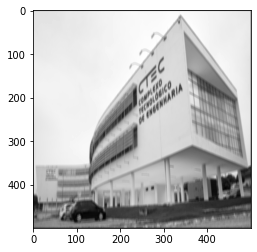

In [ ]:
plt.imshow(features_maps[0, :, :, 0],cmap="gray") # plot 1st image's 1st feature map

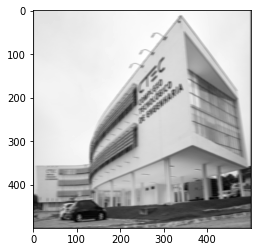

In [ ]:
plt.imshow(features_maps[0, :, :, 1],cmap='gray') # plot 1st image's 2nd feature map
plt.show()

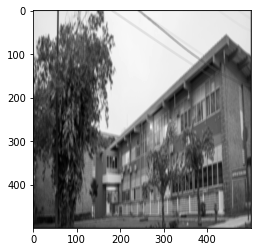

In [ ]:
plt.imshow(features_maps[1, :, :, 0],cmap="gray") # plot 2nd image's 1st feature map

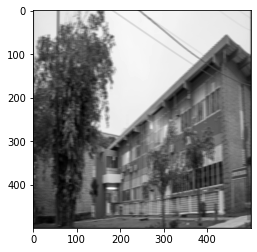

In [ ]:
plt.imshow(features_maps[1, :, :, 1],cmap="gray") # plot 2nd image's 2st feature map

### 1.2.2 How to use filter size, padding, and stride

The convolutional layer in convolutional neural networks systematically applies **filters** to an input and creates output **feature maps**. Although the convolutional layer is very simple, it is capable of achieving sophisticated and impressive results. Nevertheless, it can be challenging to develop an intuition for how the shape of the filters impacts the shape of the output feature map
and how related configuration **hyperparameters** such as **padding** and **stride** should be configured.

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1jSTsFU_o3QWiAl7es4x9a8AibkG0YTM4"></center>




In a convolutional neural network, a **convolutional layer** is responsible for the systematic application of one or more filters to an input. 

> The multiplication of the filter to the input image results in a single output.

The input is typically three-dimensional images (e.g. rows,
columns and channels), and in turn, **the filters are also three-dimensional with the same number of channels and fewer rows and columns than the input image**. As such, the filter is repeatedly applied to each part of the input image, resulting in a two-dimensional output map of activations, called a **feature map**. Keras provides an implementation of the convolutional layer called a [Conv2D layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

> It requires that you specify the expected shape of the input images in terms of rows (height), columns (width), and channels (depth) or [rows, columns, channels]. 

The filter contains the **weights that must be learned during the training** of the layer. The filter weights represent the structure or feature that the filter will detect and the strength of the activation indicates the degree to which the feature was detected. 

> The layer requires that both the number of filters be specified and that the shape of the filters be specified. 

We can demonstrate this with a small example.

In [ ]:
# example of using a single convolutional layer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

# define input data
data = [[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0]]

data = np.asarray(data)
data = data.reshape(1, 7, 7, 1)

# create model
model = Sequential()
model.add(Conv2D(1, (3,3), input_shape=(7, 7, 1)))

# summarize model
model.summary()

# 10 parameters
# 3 x 3 (filter)  x 1 (one filter) x 1 (channel) + 1 (bias) = 10

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 5, 5, 1)           10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Running the example first summarizes the structure of the model. Of note is that the single hidden convolutional layer will take the 7 × 7 pixel input image and will produce a feature map with the dimensions of 5 × 5. We can also see that the layer has 10 parameters, that is nine weights for the filter (3 × 3) and one
weight for the bias. 




<center><img width="600" src="https://drive.google.com/uc?export=view&id=1iAic6I1KInaTdO3Rm9FSFQxhu1z0UJfo"></center>



In [ ]:
# example of using a single convolutional layer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

# define input data
data = [[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0]]

data = np.asarray(data)
data = data.reshape(1, 7, 7, 1)

# create model
model = Sequential()

# stride = 2
model.add(Conv2D(1, (3,3), input_shape=(7, 7, 1),strides=2))

# summarize model
model.summary()

# 10 parameters
# 3 x 3 (filter)  x 1 (one filter) x 1 (channel) + 1 (bias) = 10

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 3, 3, 1)           10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________





<center><img width="600" src="https://drive.google.com/uc?export=view&id=1H4KRB45KFEWKrVZBme-Wq1yLZrVQr-vK"></center>


By default, a filter starts at the left of the image with the left-hand side of the filter sitting on the far left pixels of the image. The filter is then stepped across the image one column at a time until the right-hand side of the filter is sitting on the far right pixels of the image. 

> An alternative approach to applying a filter to an image is to ensure that each pixel in the image is given an opportunity to be at the center of the filter. This is know as **Border Effect Problem**.

By default (**padding = 0**), this is not the case, as the **pixels on the edge of the input are only ever exposed to the edge of the filter**. 

> By starting the filter outside the frame of the image, it gives the pixels on the border of the image more of an
opportunity for interacting with the filter.

The addition of pixels to the edge of the image is called **padding**. In Keras, this is specified via the **padding** argument on the **Conv2D** layer, which has the default value of **valid** (no padding). This means that the filter is applied only to valid ways to the input. The padding
value of **same** calculates and adds the padding required to the input image (or feature map) to ensure that the output has the same shape as the input. The example below adds padding to
the convolutional layer in our worked example.

In [ ]:
# example of using a single convolutional layer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

# define input data
data = [[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0]]

data = np.asarray(data)
data = data.reshape(1, 7, 7, 1)

# create model
model = Sequential()

# stride = 1
model.add(Conv2D(1, (3,3), padding="same" ,input_shape=(7, 7, 1),strides=1))

# summarize model
model.summary()

# 10 parameters
# 3 x 3 (filter) x 1 (one filter) x 1 (channel) + 1 (bias) = 10

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 7, 7, 1)           10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


## 1.3 How pooling layers work

Convolutional layers in a convolutional neural network summarize the presence of features in an input image. 

> A problem with the output feature maps is that they are sensitive to the location of the features in the input. 

One approach to address this sensitivity is to downsample the
feature maps. This has the effect of making the resulting downsampled feature maps more robust to changes in the position of the feature in the image, referred to by the technical phrase **local translation invariance**. **Pooling layers** provide an approach to down sampling feature maps by summarizing the presence of features in patches of the feature map. Two common pooling methods are **average pooling** and **max pooling** that summarize the average presence of a feature and the most activated presence of a feature respectively.

<center><img width="400" src="https://drive.google.com/uc?export=view&id=1x-vZQMPXxu4pzMKVvWxpY244z4Uspnm8"></center><center>Invariance to small translations</center>

A pooling layer is a new layer added after the convolutional layer. Specifically, after a nonlinearity (e.g. ReLU) has been applied to the feature maps output by a convolutional layer;
for example the layers in a model may look as follows:

1. Input Image.
2. Convolutional Layer.
3. Nonlinearity.
4. Pooling Layer.

Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small
rectangular receptive field. You must define its **size**, the **stride**, and the **padding** type, just like before. However, **a pooling neuron has no weights**; all it does is aggregate the inputs using an aggregation function such as the **max** or **mean**.

<center><img width="400" src="https://drive.google.com/uc?export=view&id=1fvojyChKmnsvUevLZUg7JBUzLGnhfLbM"><img width="300" src="https://drive.google.com/uc?export=view&id=1BAXLRPBwtZBLYEEBAXgAGg2rLJB51wan"></center>


In [ ]:
# example of using a single convolutional layer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from keras.layers import MaxPooling2D

# define input data
data = [[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0],
[0, 0, 0, 1, 1, 0, 0]]

data = np.asarray(data)
data = data.reshape(1, 7, 7, 1)

# create model
model = Sequential()

# stride = 1
model.add(Conv2D(1, (3,3), activation="relu", padding="same",input_shape=(7, 7, 1),strides=1))

# filter 2x2, strides=2, padding=0.
# note the 
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding="valid"))

# summarize model
model.summary()

# 10 parameters
# 3 x 3 (filter) x 1 (one filter) x 1 (channel) + 1 (bias) = 10

# pooling layer doesn't parameter

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 7, 7, 1)           10        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 1)           0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


# 2.0 Case study I: signs dataset

## 2.1 Introduction


One afternoon, with some friends we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset. It's now your job to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the [SIGNS dataset](https://www.kaggle.com/datamunge/sign-language-mnist). The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.


<center><img width="600" src="https://drive.google.com/uc?export=view&id=1Qz_B0IjzLrp77cBWIz6DVTsG3l9PSFKr"></center>
<center><b>Figure 1</b>: SIGNS dataset <br></center>


In [ ]:
%%capture
!pip install wandb

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import time
import datetime
import pytz
#from mlxtend.plotting import plot_decision_regions
import wandb
from wandb.keras import WandbCallback

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
# download the dataset
!wget wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=11QDIDqL38Gy2jSsYjyOCtu-G2aELhwJL' -O train_signs.h5
!wget wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KEM0DGO4hMflNcKNbB4x70QZf260XLbY' -O test_signs.h5
!wget wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1n_XZGioRTAI0qYd7jR1QObUmnWW1XJTl' -O thumbs_up.jpg



Run the following code to load the dataset.

In [ ]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Change the index below and run the cell to visualize some examples in the dataset.

y = 5


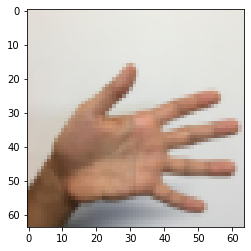

In [ ]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

In [ ]:
# Normalize image vectors
train_x = X_train_orig/255.
test_x = X_test_orig/255.
# Convert training and test labels to one hot matrices
train_y = tf.keras.utils.to_categorical(Y_train_orig).squeeze()
test_y = tf.keras.utils.to_categorical(Y_test_orig).squeeze()

print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(test_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x.shape))
print ("Y_test shape: " + str(test_y.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 2.2 Baseline Model

In [ ]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1)
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1)

# Normalize image vectors
train_base_x = X_train_flatten/255.
test_base_x = X_test_flatten/255.
# Convert training and test labels to one hot matrices
train_y = tf.keras.utils.to_categorical(Y_train_orig).squeeze()
test_y = tf.keras.utils.to_categorical(Y_test_orig).squeeze()

print ("number of training examples = " + str(train_base_x.shape[0]))
print ("number of test examples = " + str(test_base_x.shape[0]))
print ("X_train shape: " + str(train_base_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_base_x.shape))
print ("Y_test shape: " + str(test_y.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 12288)
Y_train shape: (1080, 6)
X_test shape: (120, 12288)
Y_test shape: (120, 6)


In [ ]:
# setup wandb
wandb.init(project="lesson05_baseline", name="lesson05_baseline_run_01")

In [ ]:
%%wandb

# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(25, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(6, activation = tf.nn.softmax,kernel_initializer="he_uniform")
                             ])

# Instantiate a logistic loss function that expects integer targets
loss = tf.keras.losses.CategoricalCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_base_x,
                    y=train_y,
                    batch_size=32,
                    epochs=500,
                    validation_data=(test_base_x,test_y),
                    verbose=0,
                    callbacks=[WandbCallback(log_weights=True)]
                    )

In [ ]:
loss, acc = model.evaluate(x=train_base_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_base_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 3ms/step - loss: 0.7494 - categorical_accuracy: 0.7926
Train loss: 0.749 - acc: 0.793
4/4 [==============================] - 0s 3ms/step - loss: 0.8449 - categorical_accuracy: 0.7167
Test loss: 0.845 - acc: 0.717


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 25)                307225    
_________________________________________________________________
dense_4 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 78        
Total params: 307,615
Trainable params: 307,615
Non-trainable params: 0
_________________________________________________________________


## 2.3 CNN Model

In [ ]:
# setup wandb
wandb.init(project="lesson05_cnn", name="lesson05_cnn_run_01")

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (5,5), activation=tf.nn.relu, input_shape=(64,64,3)),
  tf.keras.layers.MaxPool2D((3,3)),
  tf.keras.layers.Conv2D(32, (5,5), activation=tf.nn.relu),
  tf.keras.layers.MaxPool2D((3,3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                51264     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3

In [ ]:
%%wandb

# classes
class_names = ['zero', 'one', 'two', 'three', 'four', 'five']

# Instantiate a logistic loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=100,
                    validation_data=(test_x,test_y),
                    callbacks=[WandbCallback(log_weights=True,
                                             data_type='image',
                                             labels=class_names)],
                    verbose=0)

In [ ]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 5ms/step - loss: 1.0564 - categorical_accuracy: 0.9870
Train loss: 1.056 - acc: 0.987
4/4 [==============================] - 0s 5ms/step - loss: 1.0815 - categorical_accuracy: 0.9750
Test loss: 1.082 - acc: 0.975


## 2.4 - Test with your own image

You can now take a picture of your hand and see the output of your model.

float32
(1, 64, 64, 3)


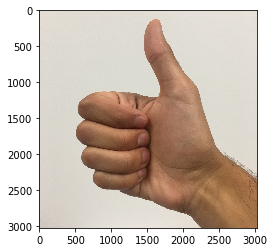

In [ ]:
# example of converting an image with the Keras API
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from skimage.transform import resize

# load the image
img = load_img('thumbs_up.jpg')

# convert to numpy array
img_array = img_to_array(img)/255
img_array_res = resize(img_array, (64,64)).reshape((1, 64,64,3))

print(img_array_res.dtype)
print(img_array_res.shape)

plt.imshow(img_array)

In [ ]:
model.predict(img_array_res).argmax()

3